In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io
import xarray as xr

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
shearfac = 0.61 # monthly: 0.55
tcwvfac = 3.1 # % 0.39%
tcabsfac = 1.2 # spread 0.1 
mmPerPercent = tcabsfac/tcwvfac

tcwvperr = 0.15 #%
sherr = 0.051 # mm / shear
shperr = sherr * mmPerPercent


In [4]:
cp4ft2 = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/cp4f_t2.nc')
cp4t2 = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/cp4_t2.nc')
cp4ftcw = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/cp4f_tcwv.nc')
cp4tcw = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/cp4_tcwv.nc')
cp4fu925 = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/cp4f_u925.nc')
cp4u925 = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/cp4_u925.nc')
cp4fu650 = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/cp4f_u650.nc')
cp4u650 = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/cp4_u650.nc')

FileNotFoundError: [Errno 2] No such file or directory: b'/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/cp4f_t2.nc'

In [253]:
(cp4ft2.mean()-cp4t2.mean())

<xarray.DataArray 't2' ()>
array(5.6822815, dtype=float32)
Coordinates:
    forecast_reference_time  object ...
    height                   float64 1.5

In [254]:
2.501e6 / (462 * cp4t2.mean()**2)   # Lv / (Rv * Tmean**2) only robust if Tchange is small. deltaT/T<< 0.1, from Kendon et al 2019. 

<xarray.DataArray 't2' ()>
array(0.06029849)
Coordinates:
    height   float64 ...

In [255]:
dr = ((cp4ftcw.mean()-cp4tcw.mean())/cp4tcw.mean()) /  (cp4ft2.mean()-cp4t2.mean()).values

In [256]:
dr

<xarray.DataArray 'tcwv' ()>
array(0.08657683, dtype=float32)
Coordinates:
    forecast_reference_time  object ...

In [257]:
np.log(1+dr*(cp4ft2.mean()-cp4t2.mean())) / (cp4ft2.mean()-cp4t2.mean())

<xarray.DataArray ()>
array(0.07040951)
Coordinates:
    forecast_reference_time  object 1997-01-01 00:00:00
    height                   float64 1.5

In [258]:
mmPerPercent*60

23.225806451612904

In [5]:
cmip_shear = '/home/ck/DIR/cornkle/figs/ENDGAME/lawrence/textfiles/Shear.txt'
cmip_tcw = '/home/ck/DIR/cornkle/figs/ENDGAME/lawrence/textfiles/TCW.txt'
cp4 = '/home/ck/DIR/cornkle/figs/ENDGAME/lawrence/textfiles/impala_jas_mean_metrics_v02.txt'

In [6]:
model_names = []
for mods in glob.glob('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/tcw_hist/prw_Clim20702099-Clim19501999*.nc'):
    tcw_map = xr.open_dataset(mods)
    model_names.append(tcw_map.attrs['model_id'])

In [7]:
def read_ascii(filepath):
    outlist = [] 
    with io.open(filepath, mode="r", encoding="utf-8") as f:
        next(f)
        next(f)
        for line in f:
            #ipdb.set_trace()
            test = line.split()
            newline = []
           
            for t in test:
                try:
                    #print(t)
                    newline.append(float(t))
                except:
                    if ('NA' or 'NaN') in t:
                        newline.append(np.nan)
                    else:
                        newline.append(t)
            outlist.append(newline)
    return outlist

In [8]:
cmip_sh = read_ascii(cmip_shear)
cmip_sh = pd.DataFrame.from_records(cmip_sh, columns=['Model', '1996', '2040', '2060', '2080'])

In [9]:
cmip_sh

,Model,1996,2040,2060,2080
0,ACCESS1-3,-2.298667,-3.441667,-4.262417,-4.412167
1,bcc-csm1-1,-10.260500,-10.230833,-11.070667,-11.131500
2,bcc-csm1-1-m,-8.673250,-8.865333,-9.274250,-9.223500
3,BNU-ESM,-8.141833,-8.228250,-8.871500,-8.406333
4,CanESM2,-9.948083,-10.651500,-10.985500,-11.364083
5,CCSM4,-9.130250,-9.799000,-9.839833,-10.163083
6,CMCC-CESM,-7.546917,-8.125250,-8.774333,-9.368333
7,CMCC-CM,-8.363083,-9.179333,-9.255583,-9.600333
8,CMCC-CMS,-8.834000,-9.145667,-9.797833,-10.420833
9,CNRM-CM5,-11.341000,-11.589583,-11.938417,-12.019833


In [10]:
cmip_tc = read_ascii(cmip_tcw)
cmip_tc = pd.DataFrame.from_records(cmip_tc, columns=['Model', '1996', '2040', '2060', '2080'])

In [11]:
cp4_asc = read_ascii(cp4)
cp4_asc = pd.DataFrame.from_records(cp4_asc, columns=['Variable', 'R25hist', 'R25fut', 'CP4hist', 'CP4fut'])

In [12]:
cp4_asc = cp4_asc.set_index('Variable')

In [13]:
cp4_asc['CP4fut']

Variable
pre_heavy      7.693070
pre_r95        3.129770
pre_r98        1.787150
shear        -12.459500
tcw           53.340300
t850         301.656000
dt850z_dy      0.838841
Name: CP4fut, dtype: float64

In [14]:
(cp4_asc['CP4fut'].t850-cp4_asc['CP4hist'].t850)

5.63900000000001

In [15]:
(cp4_asc['CP4fut'].tcw-cp4_asc['CP4hist'].tcw)/ cp4_asc['CP4hist'].tcw

0.5270189802754002

In [16]:
((cp4_asc['CP4fut'].tcw-cp4_asc['CP4hist'].tcw) / cp4_asc['CP4hist'].tcw) / (cp4_asc['CP4fut'].t850-cp4_asc['CP4hist'].t850)

0.09345965246948026

In [17]:
cp4_asc = cp4_asc.drop(['t850', 'dt850z_dy','pre_heavy', 'pre_r98'])

In [18]:
cp4_asc

,R25hist,R25fut,CP4hist,CP4fut
Variable,,,,
pre_r95,0.998476,1.59876,1.69172,3.12977
shear,-9.666430,-11.26620,-9.96798,-12.45950
tcw,34.593100,53.23910,34.93100,53.34030


In [19]:
cp4_diff = cp4_asc.copy()
cp4_diff['R25DELTA'] = cp4_asc['R25fut']-cp4_asc['R25hist']  # CP4 fut is deltaX
cp4_diff['CP4DELTA'] = cp4_asc['CP4fut']-cp4_asc['CP4hist']

In [20]:
cp4_diff

,R25hist,R25fut,CP4hist,CP4fut,R25DELTA,CP4DELTA
Variable,,,,,,
pre_r95,0.998476,1.59876,1.69172,3.12977,0.600284,1.43805
shear,-9.666430,-11.26620,-9.96798,-12.45950,-1.599770,-2.49152
tcw,34.593100,53.23910,34.93100,53.34030,18.646000,18.40930


In [21]:
cp4_diff['R25DELTA'].pre_r95  / cp4_diff['R25hist'].pre_r95

0.6012002291492233

In [22]:
cp4_diff['CP4DELTA'].pre_r95  / cp4_diff['CP4hist'].pre_r95

0.8500520180644553

In [23]:
cp4_diff['R25DELTA'].tcw  / cp4_diff['R25hist'].tcw   

0.5390092243828972

In [24]:
cp4_diff['CP4DELTA'].tcw  / cp4_diff['CP4hist'].tcw

0.5270189802754002

In [25]:
cp4_precip = cp4_diff.copy()
cp4_error = cp4_diff.copy()

In [26]:
cp4_diff['R25_Drel'] = cp4_diff['R25DELTA']/cp4_diff['R25hist']*100 # CP4 hist is relative change
cp4_diff['CP4_Drel'] = cp4_diff['CP4DELTA']/cp4_diff['CP4hist']*100

In [27]:
cp4_diff  #### pure variable change

,R25hist,R25fut,CP4hist,CP4fut,R25DELTA,CP4DELTA,R25_Drel,CP4_Drel
Variable,,,,,,,,
pre_r95,0.998476,1.59876,1.69172,3.12977,0.600284,1.43805,60.120023,85.005202
shear,-9.666430,-11.26620,-9.96798,-12.45950,-1.599770,-2.49152,16.549750,24.995235
tcw,34.593100,53.23910,34.93100,53.34030,18.646000,18.40930,53.900922,52.701898


In [28]:
cp4_precip.loc['shear'] = cp4_precip.loc['shear']*shearfac*-1/mmPerPercent
cp4_precip.loc['tcw'] = cp4_precip.loc['tcw']*tcwvfac

In [29]:
cp4_error.loc['shear'] = cp4_error.loc['shear']*shperr*-1
cp4_error.loc['tcw'] = cp4_error.loc['tcw']*tcwvperr

In [30]:
cp4_sahel_shear = ((cp4fu650.mean()-cp4fu925.mean()) - (cp4u650.mean()-cp4u925.mean()))
cp4_sahel_shear_prcp = cp4_sahel_shear  *shearfac/mmPerPercent

NameError: name 'cp4fu650' is not defined

In [285]:
cp4_sahel_tcw = ((cp4ftcw.mean()) - (cp4tcw.mean()))
cp4_sahel_tcw_prcp = cp4_sahel_tcw *tcwvfac

In [31]:
cmip_tcw_map = xr.open_mfdataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/tcw_hist/prw_Clim20702099-Clim19501999*.nc', concat_dim='model', combine='nested').sel(lon=slice(-5,15), lat=slice(9,20)).load()

In [32]:
model_names = []
for mods in glob.glob('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/tcw_hist/prw_Clim20702099-Clim19501999*.nc'):
    tcw_map = xr.open_dataset(mods)
    model_names.append(tcw_map.attrs['model_id'])

In [33]:
cmip_sh_map = xr.open_mfdataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/shear_hist/ua@925-ua@600_Clim20702099-Clim19501999*.nc', concat_dim='model', combine='nested').sel(lon=slice(-5,15), lat=slice(9,20)).load()

In [34]:
cmip_sahel_tcw = cmip_tcw_map.mean(['lat','lon'])
cmip_sh_map = cmip_sh_map['unknown'].where(cmip_sh_map['unknown'].values<100)
cmip_sahel_sh = cmip_sh_map.mean(['lat','lon'])*-1

In [35]:
cmip_sahel_sh = cmip_sahel_sh#.where(cmip_sahel_sh['unknown'].values>-1000)
cmip_sahel_tcw = cmip_sahel_tcw['unknown']

In [36]:
cmip_sahel_sh.values

array([-3.17023981, -3.60296961, -1.07435183, -1.66617556, -1.76984575,
       -0.86416562, -1.74178311, -1.99919643, -1.98889835, -1.00684229,
       -0.86744676, -2.49254178, -0.88397638, -1.44819457, -2.53560884,
       -1.99170406, -1.66419275, -1.61568792, -1.81994786, -1.79690177,
       -1.47236591, -3.73615083, -3.19340737, -1.69525235, -2.53344802,
       -2.1053371 , -3.90096895, -3.57561613, -0.27246153, -1.27331593,
       -1.86010754, -1.58878397, -1.51049993, -2.80401522, -3.1006    ,
       -1.08033086, -0.34977862, -1.73010182])

In [37]:
cp4_error

,R25hist,R25fut,CP4hist,CP4fut,R25DELTA,CP4DELTA
Variable,,,,,,
pre_r95,0.998476,1.598760,1.691720,3.129770,0.600284,1.438050
shear,0.190834,0.222417,0.196787,0.245975,0.031583,0.049187
tcw,5.188965,7.985865,5.239650,8.001045,2.796900,2.761395


In [38]:
cmip_sh_diff = cmip_sh
cmip_tc_diff = cmip_tc

In [39]:
cmip_sh_diff['2040'] = cmip_sh['2040']-cmip_sh['1996']
cmip_sh_diff['2060'] = cmip_sh['2060']-cmip_sh['1996']
cmip_sh_diff['2080'] = cmip_sh['2080']-cmip_sh['1996']

In [40]:
cmip_tc_diff['2040'] = cmip_tc['2040']-cmip_tc['1996']
cmip_tc_diff['2060'] = cmip_tc['2060']-cmip_tc['1996']
cmip_tc_diff['2080'] = cmip_tc['2080']-cmip_tc['1996']

In [41]:
cmip_tc_precip = cmip_tc_diff[['2040','2060','2080']]*tcabsfac
cmip_tc_perc = cmip_tc_diff[['2040','2060','2080']]*tcwvfac
cmip_sh_precip = cmip_sh_diff[['2040','2060','2080']]*shearfac*-1

In [42]:
cmip_tc_perc = cmip_tc_diff[['2040','2060','2080']]*tcabsfac/mmPerPercent
cmip_sh_perc = cmip_sh_diff[['2040','2060','2080']]*shearfac*-1/mmPerPercent

In [43]:
cmip_shtc_precip = cmip_tc_perc + cmip_sh_perc

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


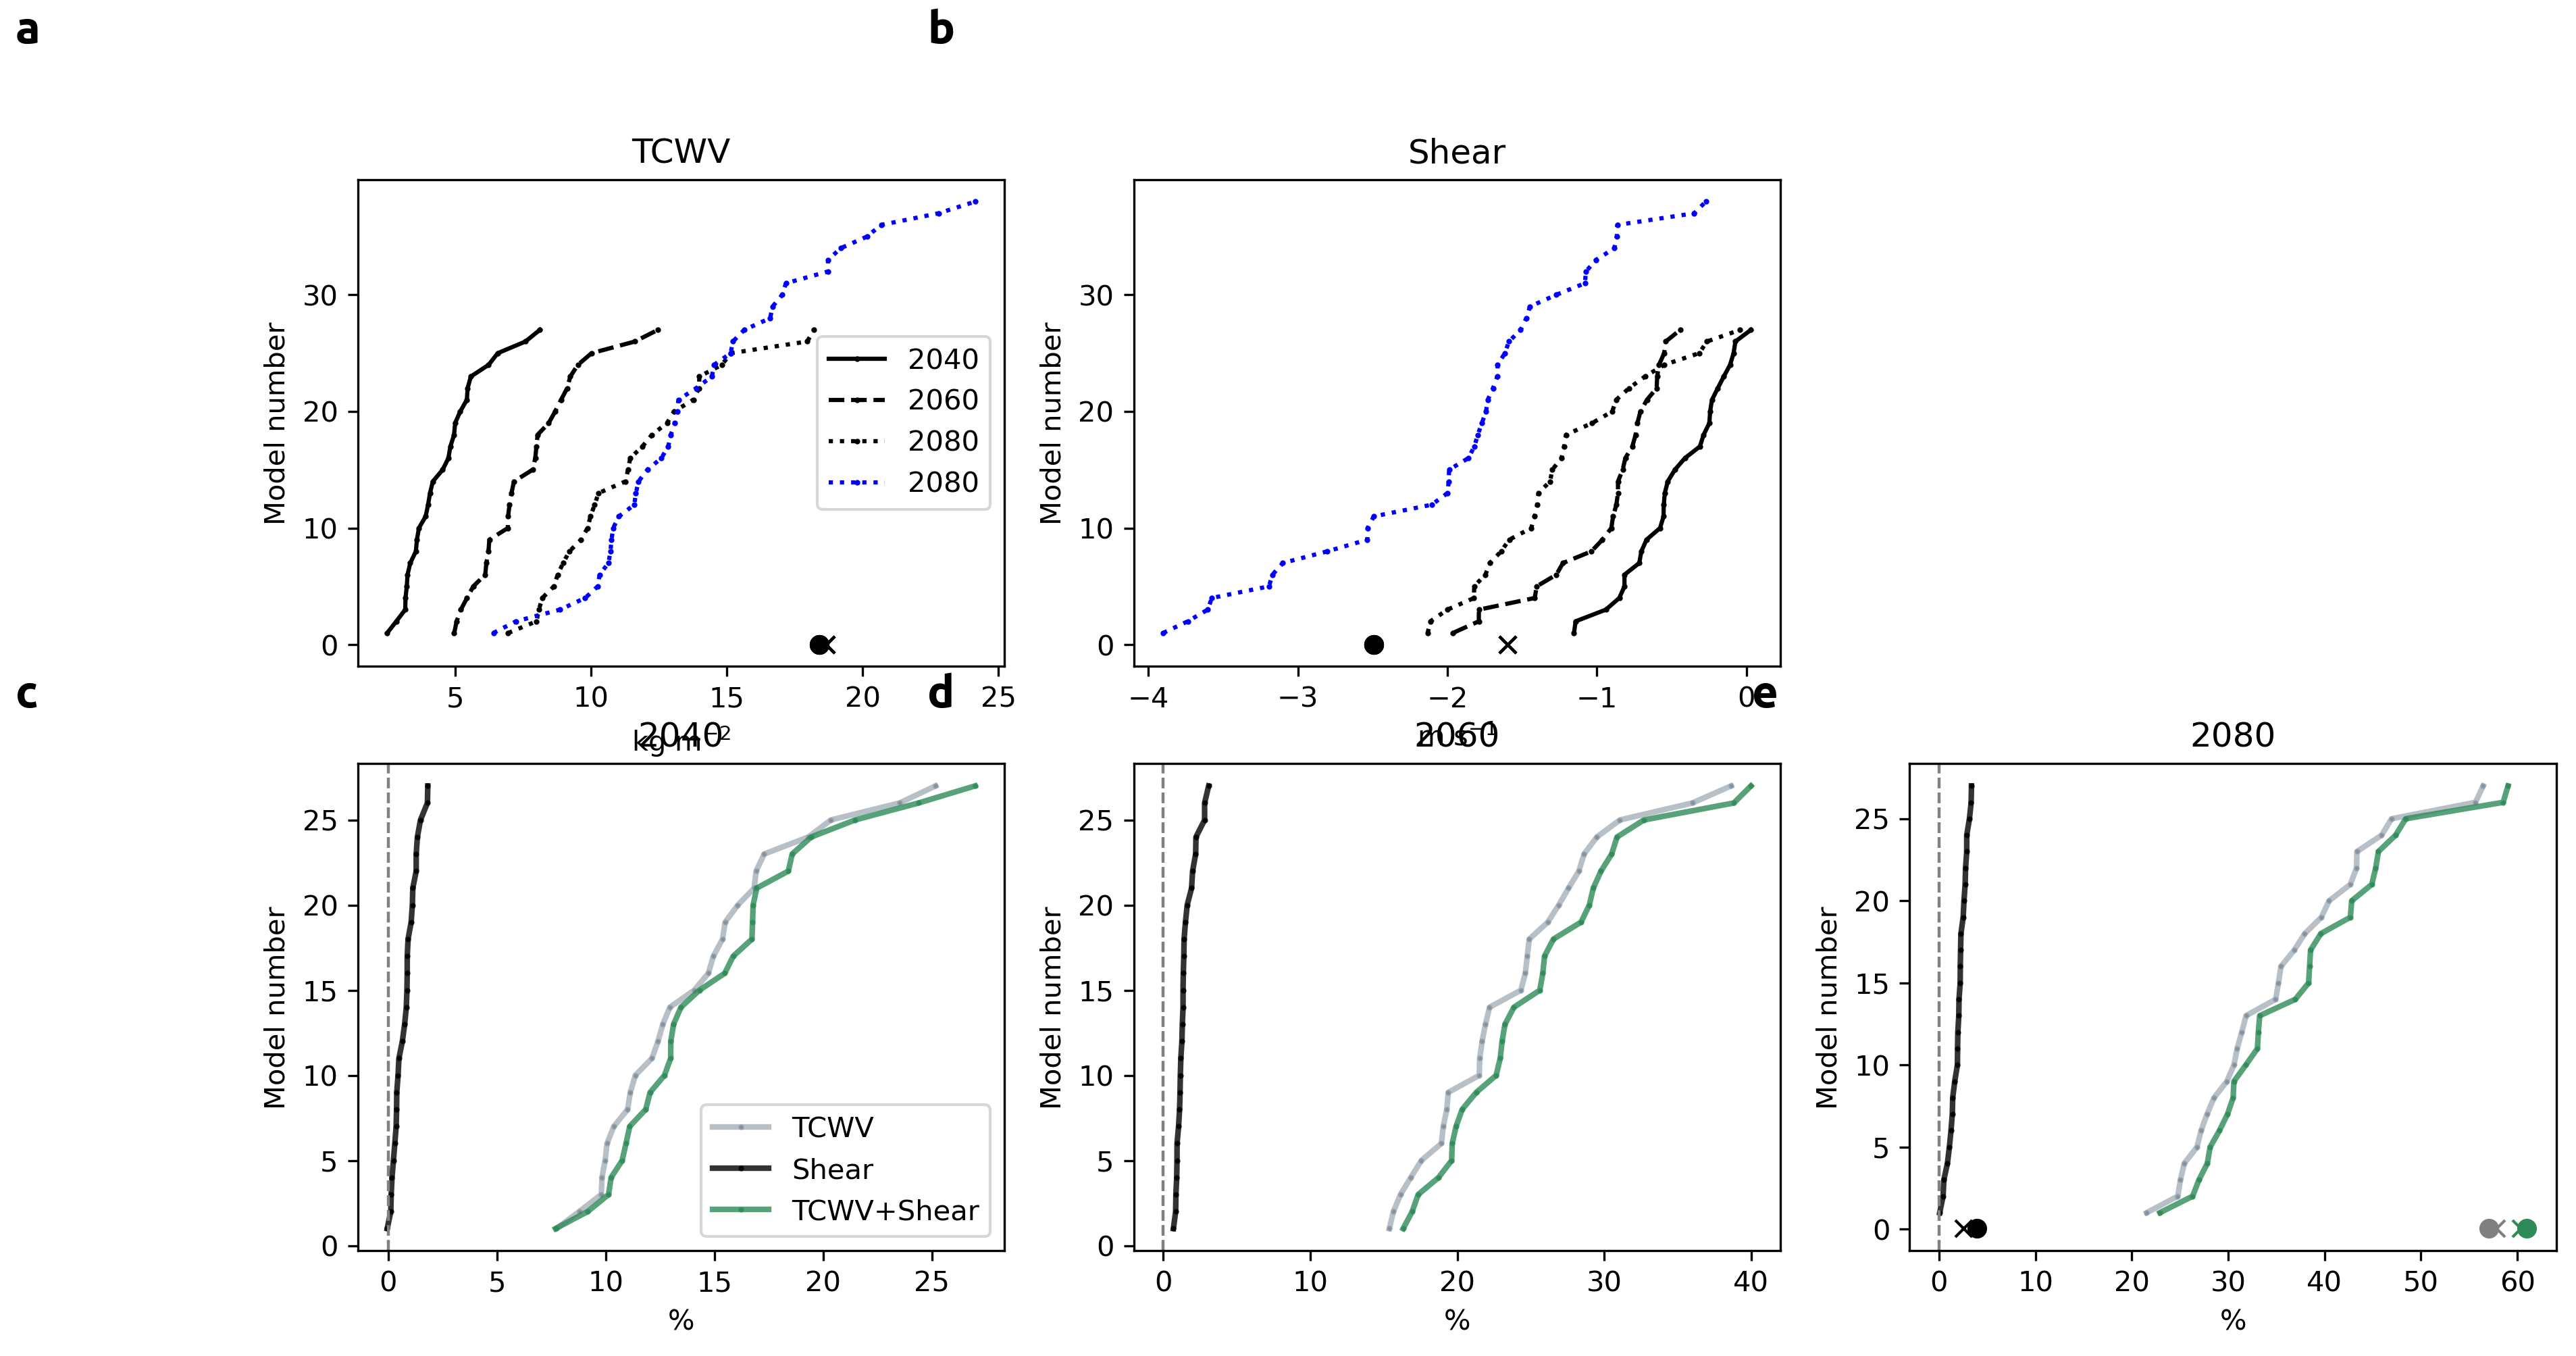

In [45]:
f = plt.figure(figsize=(14,7), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)


linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########
    x = cmip_tc_diff[stry].values[np.isfinite(cmip_tc_diff[stry].values)]
    cumulative = np.sort(x)

    ax1.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=1, color='k', linestyle=linestyle[ids])
    
    
    
    if ids ==2:
        x = cmip_sahel_tcw.values[np.isfinite(cmip_sahel_tcw.values)]
        cumulative = np.sort(x)

        ax1.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=1, color='b', linestyle=linestyle[ids])
    
    
    #ax1.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax1.set_title('TCWV')
    ax1.set_xlabel('kg m$^{-2}$')
    ax1.set_ylabel('Model number')

    ax1.plot(cp4_diff.loc['tcw', 'R25DELTA'],0.03, color='k', marker='x')
    ax1.plot(cp4_diff.loc['tcw', 'CP4DELTA'],0.03, color='k', marker='o')
    #ax1.plot(cp4_sahel_tcw, 0.03, color='grey', marker='o')
    ax2.plot(cp4_diff.loc['shear', 'R25DELTA'],0.03, color='k', marker='x')
    ax2.plot(cp4_diff.loc['shear', 'CP4DELTA'],0.03, color='k', marker='o')
    #ax2.plot(cp4_sahel_shear, 0.03, color='grey', marker='o')

    #ax1.axvline(0, linestyle='dashed', lw=1)
    
    
    #
    x = cmip_sh_diff[stry].values[np.isfinite(cmip_sh_diff[stry].values)]
    cumulative = np.sort(x)

    ax2.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=1, color='k', linestyle=linestyle[ids])
    
    
    if ids == 2:
        x = cmip_sahel_sh.values[np.isfinite(cmip_sahel_sh.values)]
        cumulative = np.sort(x)

        ax2.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=1, color='b', linestyle=linestyle[ids])
        
        
    
    
    ax2.set_title('Shear')
    ax2.set_xlabel('m s$^{-1}$')
    ax2.set_ylabel('Model number')
    #plt.axvline(0, linestyle='dashed', lw=1)

    ax = f.add_subplot(2,3,ids+4)
    ##########
    x = cmip_tc_perc[stry].values[np.isfinite(cmip_tc_perc[stry].values)]
    cumulative = np.sort(x)

    ax.plot(cumulative, np.arange(len(cumulative))+1, color='slategrey', alpha=0.5, lw=2, label='TCWV', marker='o', markersize=1)
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #shplot = hist2d.basic_1d_binning(cmip_sh_precip['2080'].values, np.arange(np.min(cmip_sh_precip['2080']), np.max(cmip_sh_precip['2080']),0.1))
    #ax.bar(shplot['xbins'], shplot['nb']/np.sum(shplot['nb']), color='k', label='Shear', width=0.1)
    ##----
    x = cmip_sh_perc[stry].values[np.isfinite(cmip_sh_perc[stry].values)]
    cumulative = np.sort(x)
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='k', alpha=0.8, lw=2, label='Shear', marker='o', markersize=1)
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #stplot = hist2d.basic_1d_binning(cmip_shtc_precip[stry].values, np.arange(np.min(cmip_shtc_precip[stry]), np.max(cmip_shtc_precip[stry]),1))
    #ax.bar(stplot['xbins'], stplot['nb']/np.sum(stplot['nb']), color='seagreen', label='TCWV+Shear')
    ##----
    x = cmip_shtc_precip[stry].values[np.isfinite(cmip_shtc_precip[stry].values)]
    cumulative = np.sort(x)
    
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='seagreen', alpha=0.8, lw=2,  label='TCWV+Shear', marker='o', markersize=1)
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')
    ##############
    if ids == 2:
        ax.plot(cp4_precip.loc['tcw', 'R25DELTA'],0.03, color='grey', marker='x')
        ax.plot(cp4_precip.loc['tcw', 'CP4DELTA'],0.03, color='grey', marker='o')
        ax.plot(cp4_precip.loc['shear', 'R25DELTA'],0.03, color='k', marker='x')
        ax.plot(cp4_precip.loc['shear', 'CP4DELTA'],0.03, color='k', marker='o')
        ax.plot(cp4_precip.loc['tcw', 'R25DELTA']+cp4_precip.loc['shear', 'R25DELTA'],0.03, color='seagreen', marker='x')
        ax.plot(cp4_precip.loc['tcw', 'CP4DELTA']+cp4_precip.loc['shear', 'CP4DELTA'],0.03, color='seagreen', marker='o')
   
    plt.xlabel('%')
    plt.ylabel('Model number')

    plt.title(stry)
    if ids == 0:
        plt.legend()
ax1.legend()
#ax2.legend()

#ipdb.set_trace()

text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.006, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.006, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.68, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_order_Sahel.png')

In [317]:
from scipy.stats import gaussian_kde

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

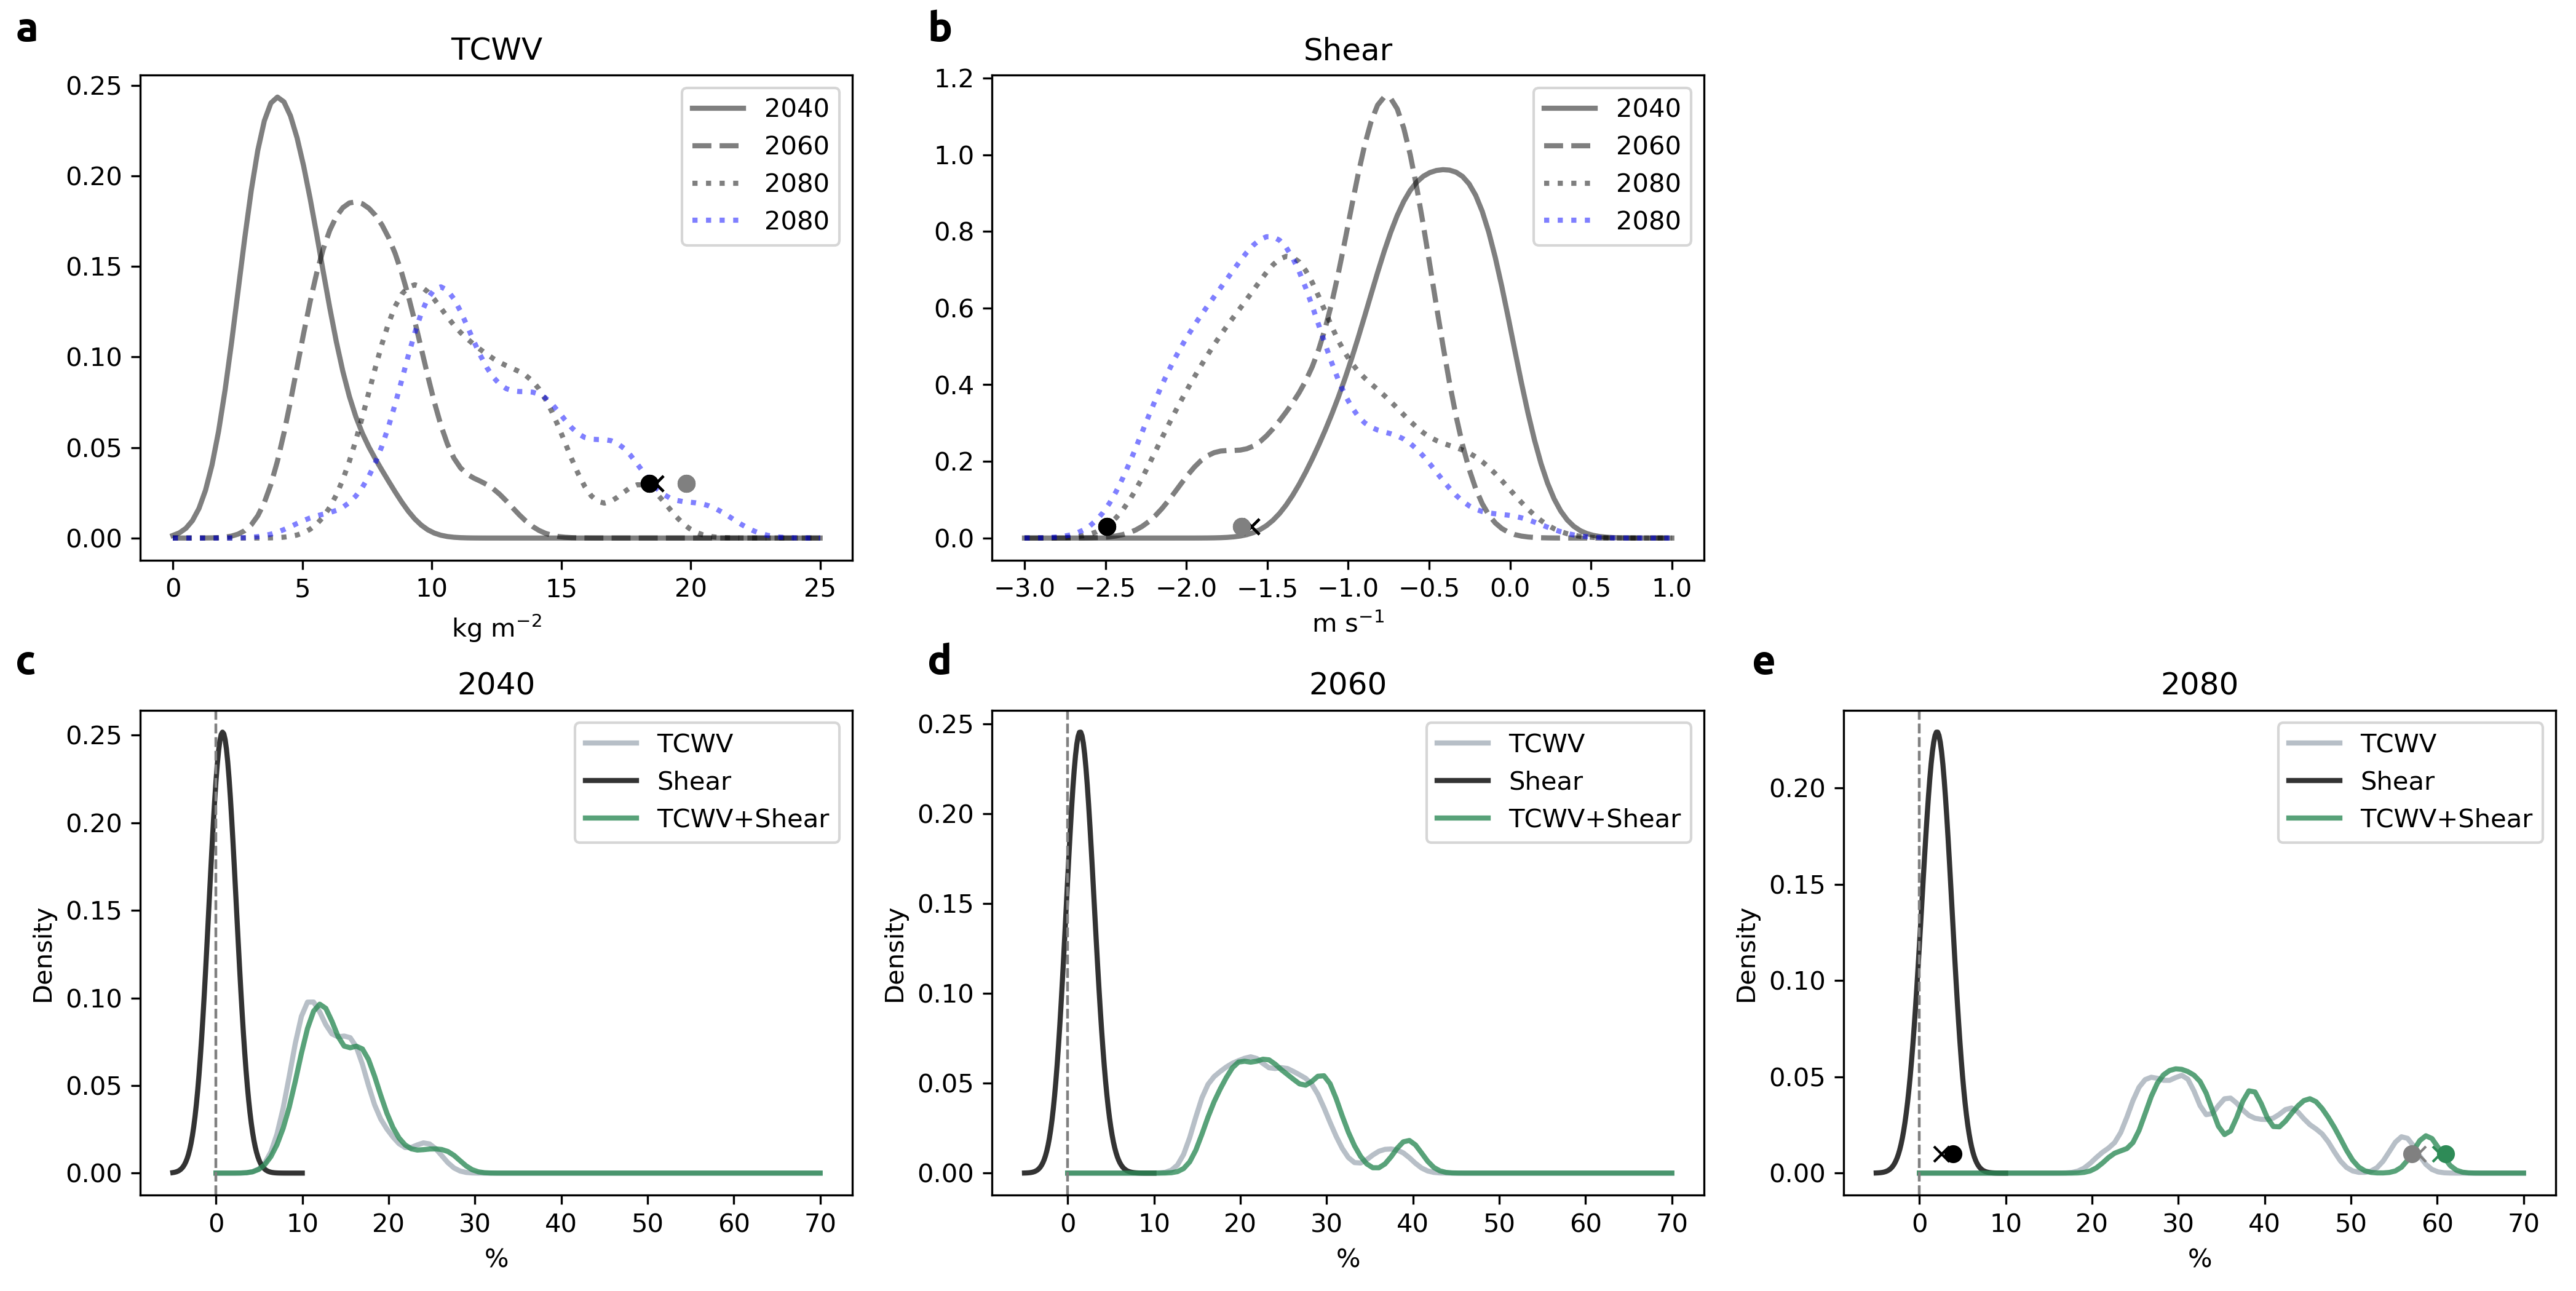

In [334]:

f = plt.figure(figsize=(14,7), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)


linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########

    x = cmip_tc_diff[stry].values[np.isfinite(cmip_tc_diff[stry].values)]
    x_grid = np.linspace(0, 25, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1)
    ax1.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax1.set_title('TCWV')
    ax1.set_xlabel('kg m$^{-2}$')
    #ax1.axvline(0, linestyle='dashed', lw=1)
    
    if ids == 2:
        x = cmip_sahel_tcw.values[np.isfinite(cmip_sahel_tcw.values)]
        x_grid = np.linspace(0, 25, 100)
        pdf = kde_scipy(x, x_grid, bandwidth=1)
        ax1.plot(x_grid, pdf, color='b', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
        ax1.set_title('TCWV')
        ax1.set_xlabel('kg m$^{-2}$')
        #ax1.axvline(0, linestyle='dashed', lw=1)
        
    
    
    #
    x = cmip_sh_diff[stry].values[np.isfinite(cmip_sh_diff[stry].values)]
    x_grid = np.linspace(-3, 1, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=0.2)
    ax2.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax2.set_title('Shear')
    ax2.set_xlabel('m s$^{-1}$')
    #plt.axvline(0, linestyle='dashed', lw=1)
    
    if ids == 2:
        
        x = cmip_sahel_sh.values[np.isfinite(cmip_sahel_sh.values)]
        x_grid = np.linspace(-3, 1, 100)
        pdf = kde_scipy(x, x_grid, bandwidth=0.2)
        ax2.plot(x_grid, pdf, color='b', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
        ax2.set_title('Shear')
        ax2.set_xlabel('m s$^{-1}$')
        #plt.axvline(0, linestyle='dashed', lw=1)
        
    ax1.plot(cp4_diff.loc['tcw', 'R25DELTA'],0.03, color='k', marker='x')
    ax1.plot(cp4_diff.loc['tcw', 'CP4DELTA'],0.03, color='k', marker='o')
    ax1.plot(cp4_sahel_tcw, 0.03, color='grey', marker='o')
    ax2.plot(cp4_diff.loc['shear', 'R25DELTA'],0.03, color='k', marker='x')
    ax2.plot(cp4_diff.loc['shear', 'CP4DELTA'],0.03, color='k', marker='o')
    ax2.plot(cp4_sahel_shear, 0.03, color='grey', marker='o')
        

    ax = f.add_subplot(2,3,ids+4)
    ##########
    #tcplot = hist2d.basic_1d_binning(cmip_tc_perc['2080'].values, np.arange(np.min(cmip_tc_perc['2080']), np.max(cmip_tc_perc['2080']),1))
    #ax.bar(tcplot['xbins'], tcplot['nb']/np.sum(tcplot['nb']), color='grey', label='TCWV')

    x = cmip_tc_perc[stry].values[np.isfinite(cmip_tc_perc[stry].values)]
    x_grid = np.linspace(0, 70, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='slategrey', alpha=0.5, lw=2, label='TCWV')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #shplot = hist2d.basic_1d_binning(cmip_sh_precip['2080'].values, np.arange(np.min(cmip_sh_precip['2080']), np.max(cmip_sh_precip['2080']),0.1))
    #ax.bar(shplot['xbins'], shplot['nb']/np.sum(shplot['nb']), color='k', label='Shear', width=0.1)
    ##----
    x = cmip_sh_perc[stry].values[np.isfinite(cmip_sh_perc[stry].values)]
    x_grid = np.linspace(-5, 10, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='k', alpha=0.8, lw=2, label='Shear')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #stplot = hist2d.basic_1d_binning(cmip_shtc_precip[stry].values, np.arange(np.min(cmip_shtc_precip[stry]), np.max(cmip_shtc_precip[stry]),1))
    #ax.bar(stplot['xbins'], stplot['nb']/np.sum(stplot['nb']), color='seagreen', label='TCWV+Shear')
    ##----
    x = cmip_shtc_precip[stry].values[np.isfinite(cmip_shtc_precip[stry].values)]
    x_grid = np.linspace(0, 70, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='seagreen', alpha=0.8, lw=2,  label='TCWV+Shear')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')
    ##############
    if ids == 2:
        ax.plot(cp4_precip.loc['tcw', 'R25DELTA'],0.01, color='grey', marker='x')
        ax.plot(cp4_precip.loc['tcw', 'CP4DELTA'],0.01, color='grey', marker='o')
        ax.plot(cp4_precip.loc['shear', 'R25DELTA'],0.01, color='k', marker='x')
        ax.plot(cp4_precip.loc['shear', 'CP4DELTA'],0.01, color='k', marker='o')
        ax.plot(cp4_precip.loc['tcw', 'R25DELTA']+cp4_precip.loc['shear', 'R25DELTA'],0.01, color='seagreen', marker='x')
        ax.plot(cp4_precip.loc['tcw', 'CP4DELTA']+cp4_precip.loc['shear', 'CP4DELTA'],0.01, color='seagreen', marker='o')
    
    plt.xlabel('%')
    plt.ylabel('Density')

    plt.title(stry)

    plt.legend()
ax1.legend()
ax2.legend()

text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.006, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.006, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.68, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.tight_layout()
plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_PDF_fullWA.png')

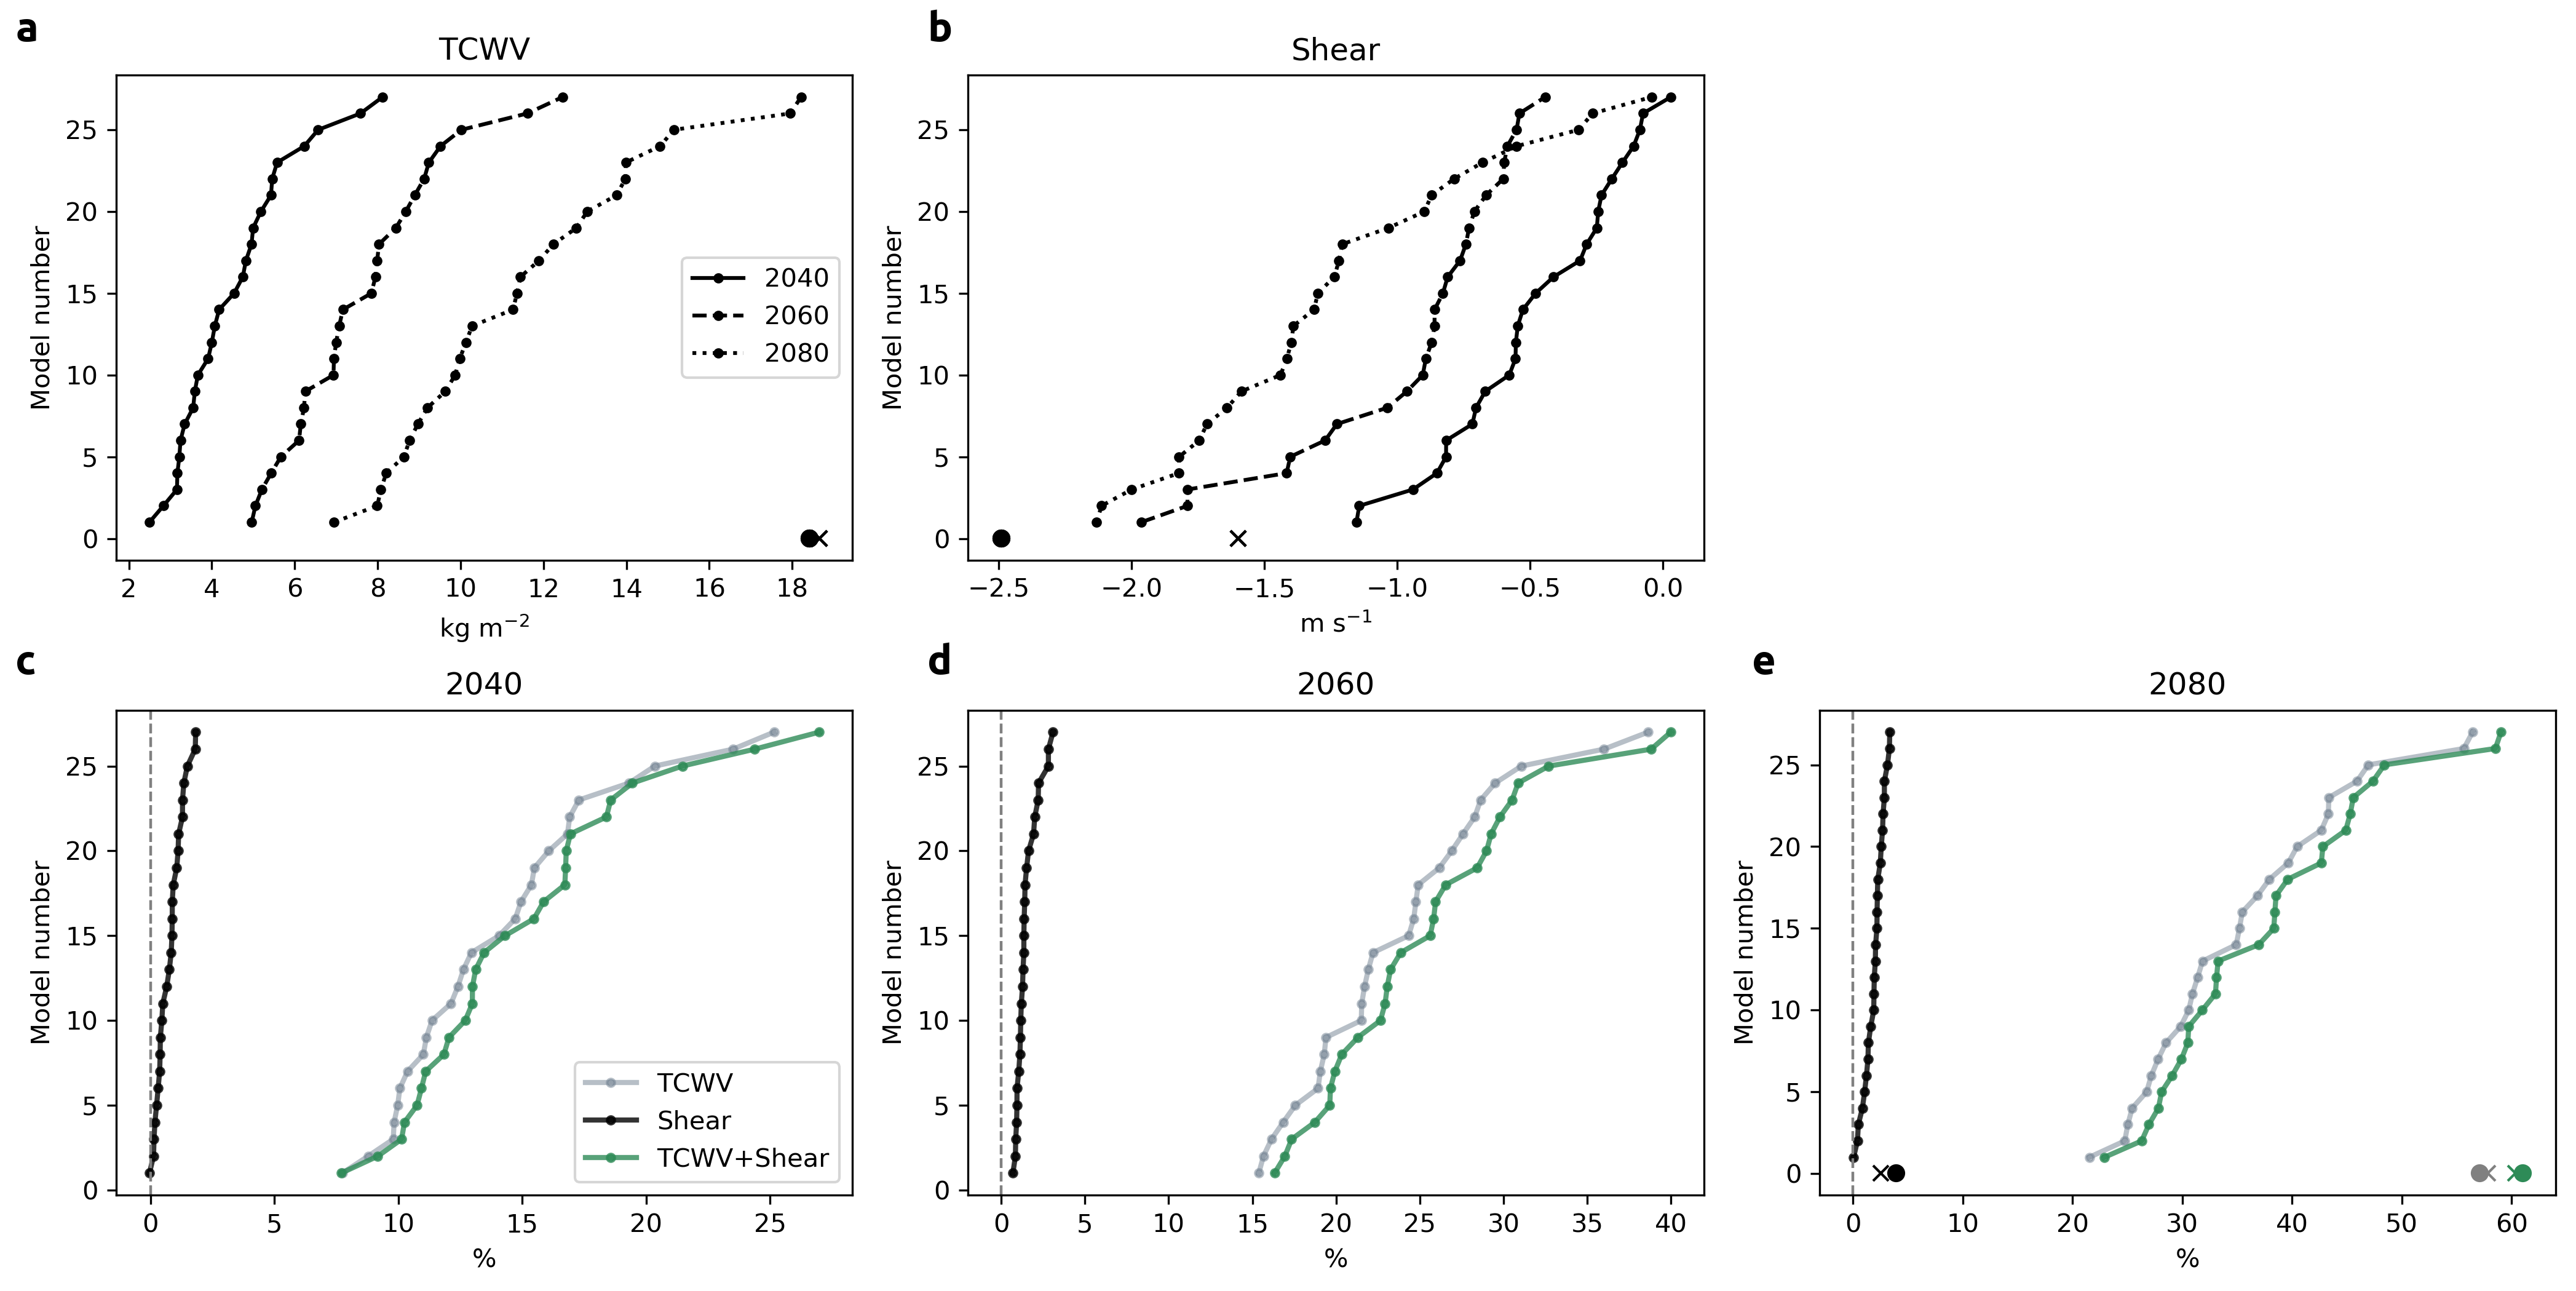

In [211]:
f = plt.figure(figsize=(14,7), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)

mk=3
linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########
    x = cmip_tc_diff[stry].values[np.isfinite(cmip_tc_diff[stry].values)]
    cumulative = np.sort(x)

    ax1.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=mk, color='k', linestyle=linestyle[ids])
    #ax1.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax1.set_title('TCWV')
    ax1.set_xlabel('kg m$^{-2}$')
    ax1.set_ylabel('Model number')

    ax1.plot(cp4_diff.loc['tcw', 'R25DELTA'],0.03, color='k', marker='x')
    ax1.plot(cp4_diff.loc['tcw', 'CP4DELTA'],0.03, color='k', marker='o')
    ax2.plot(cp4_diff.loc['shear', 'R25DELTA'],0.03, color='k', marker='x')
    ax2.plot(cp4_diff.loc['shear', 'CP4DELTA'],0.03, color='k', marker='o')

    #ax1.axvline(0, linestyle='dashed', lw=1)
    
    
    #
    x = cmip_sh_diff[stry].values[np.isfinite(cmip_sh_diff[stry].values)]
    cumulative = np.sort(x)

    ax2.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=mk, color='k', linestyle=linestyle[ids])
    ax2.set_title('Shear')
    ax2.set_xlabel('m s$^{-1}$')
    ax2.set_ylabel('Model number')
    #plt.axvline(0, linestyle='dashed', lw=1)

    ax = f.add_subplot(2,3,ids+4)
    ##########
    x = cmip_tc_perc[stry].values[np.isfinite(cmip_tc_perc[stry].values)]
    cumulative = np.sort(x)

    ax.plot(cumulative, np.arange(len(cumulative))+1, color='slategrey', alpha=0.5, lw=2, label='TCWV', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #shplot = hist2d.basic_1d_binning(cmip_sh_precip['2080'].values, np.arange(np.min(cmip_sh_precip['2080']), np.max(cmip_sh_precip['2080']),0.1))
    #ax.bar(shplot['xbins'], shplot['nb']/np.sum(shplot['nb']), color='k', label='Shear', width=0.1)
    ##----
    x = cmip_sh_perc[stry].values[np.isfinite(cmip_sh_perc[stry].values)]
    cumulative = np.sort(x)
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='k', alpha=0.8, lw=2, label='Shear', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #stplot = hist2d.basic_1d_binning(cmip_shtc_precip[stry].values, np.arange(np.min(cmip_shtc_precip[stry]), np.max(cmip_shtc_precip[stry]),1))
    #ax.bar(stplot['xbins'], stplot['nb']/np.sum(stplot['nb']), color='seagreen', label='TCWV+Shear')
    ##----
    x = cmip_shtc_precip[stry].values[np.isfinite(cmip_shtc_precip[stry].values)]
    cumulative = np.sort(x)
    
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='seagreen', alpha=0.8, lw=2,  label='TCWV+Shear', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')
    ##############
    if ids == 2:
        ax.plot(cp4_precip.loc['tcw', 'R25DELTA'],0.03, color='grey', marker='x')
        ax.plot(cp4_precip.loc['tcw', 'CP4DELTA'],0.03, color='grey', marker='o')
        ax.plot(cp4_precip.loc['shear', 'R25DELTA'],0.03, color='k', marker='x')
        ax.plot(cp4_precip.loc['shear', 'CP4DELTA'],0.03, color='k', marker='o')
        ax.plot(cp4_precip.loc['tcw', 'R25DELTA']+cp4_precip.loc['shear', 'R25DELTA'],0.03, color='seagreen', marker='x')
        ax.plot(cp4_precip.loc['tcw', 'CP4DELTA']+cp4_precip.loc['shear', 'CP4DELTA'],0.03, color='seagreen', marker='o')
   
    plt.xlabel('%')
    plt.ylabel('Model number')

    plt.title(stry)
    if ids == 0:
        plt.legend()
ax1.legend()
#ax2.legend()

#ipdb.set_trace()

text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.006, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.006, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.68, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_marker+uncertainty.png')